### Neural Networks
Many machine learning prediction problems are rooted in complex data and its non-linear relationships between features. Neural networks are a class of models that can learn these non-linear interactions between variables.

1. <b>import data</b>
2. <b>Neurons</b>
3. <b>Cost Function</b>
4. <b> The Gradient</b>
5. <b>Two layer Network</b>
6. <b>Neural network</b>
7. <b>Multiple Neural Network Cost Function</b>
8. <b>Backpropagation</b>
9. <b>Predicting Iris Flowers</b>

In [1]:
import json
import matplotlib
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import roc_auc_score

warnings.simplefilter("ignore")
root = r"/Users/Kenneth-Aristide/anaconda3/bin/python_prog/ML/styles/bmh_matplotlibrc.json"
s = json.load(open(root))
matplotlib.rcParams.update(s)
% matplotlib inline

In [2]:
headers = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv("/Users/Kenneth-Aristide/anaconda3/bin/python_prog/ML/data/iris.csv", names = headers)
iris.tail()

,sepal_length,sepal_width,petal_length,petal_width,species
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [3]:
iris.sepal_length =( iris.sepal_length  - iris.sepal_length.mean())/ iris.sepal_length.std()
iris.sepal_width =( iris.sepal_width  - iris.sepal_width.mean())/ iris.sepal_width.std()
iris.petal_length =( iris.petal_length - iris.petal_length.mean())/ iris.petal_length.std()
iris.sepal_length =( iris.petal_width  - iris.petal_width.mean())/ iris.petal_width.std()

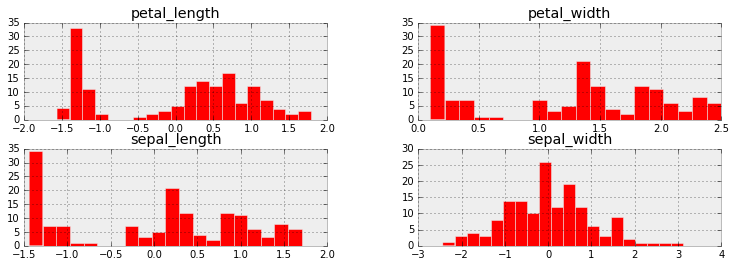

In [4]:
figsize(12.5, 4)
shuffled_index = np.random.permutation(iris.index)
iris = iris.loc[shuffled_index, :]
iris.hist(bins = 20, color = "r");

So far we have talked about methods which do not allow for a large amount of non-linearity. For example, in the two dimensional case shown below, we want to find a function that can cleanly seperate the X's from the O's.
<img src="http://localhost:8888/files/python_prog/ML/img/iris.png", width = 300/>
Neither a linear model nor logistic model is capable of building such a function, so we must explore other options like $neural$ $networks$. Neural networks are very loosely inspired by the structure of neurons in the human brain. These models are built by using a series of activation units, known as neurons, to make predictions of some outcome. Neurons take in some input, apply a transformation function, and return an output. Below we see a representation of a neuron.
<img src="http://localhost:8888/files/python_prog/ML/img/iris2.png", width = 300/>
This neuron is taking in 5 units represented as x, a bias unit, and 4 features. This bias unit (1) is similar in concept to the intercept in linear regression and it will shift the activity of the neuron to one direction or the other. These units are then fed into an activation function $h$.
We will use the popular sigmoid (logistic) activation function because it returns values between 0 and 1 and can be treated as probabilities.<br><br>
<center><i><b>Sigmoid Function</b></i> : $g(z) = \frac{1}{1 + \exp(-z)}$</center><br>
This sigmoid function then leads to the corresponding $activation$ $function$ : <br><br>
<center><i><b>Sigmoid Activation Function</b></i> : $h_{\theta}(x) = \frac{1}{1 + \exp(-\Theta^Tx)} = 
\frac{1}{1 + \exp(-(\theta_01 + \theta_1x_1 + \theta_2x_2))}$</center>

In [5]:
iris["ones"] = np.ones(iris.shape[0])
X = iris[['ones', 'sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
y = (iris.species == 'Iris-versicolor').values.astype(int)

#randomly initialize the thetas
theta_init = np.random.normal(0, 0.01, size = (5, 1))

def sigmoid_activation(x, theta):
    """
    Convenience function:
        compute the sigmoid activation of the NNet
    """
    x = np.asarray(x)
    theta = np.asarray(theta)
    frac = 1 + np.exp(-np.dot(theta.T, x))
    return 1 / frac

a1 = sigmoid_activation(X[0], theta_init)
a1

array([ 0.49928276])

### Cost Function
We can train a single neuron as a two layer network using <i>gradient descent</i>. As we learned in $GradientDescent.py$, we need to minimize a cost function which measures the error in our model. The cost function measures the difference between the desired output and actual output, defined as:
$$J(\Theta) = -\frac{1}{m} \sum_{i=1}^m (y_i * log(h_{\theta}(x_i)) + (1 - y_i) * log(1 - h_{\theta}(x_i)) $$

Since our targets,$y_i$,are binary, either $y_i$ or $(1− y_i)$ will equal zero. One of the terms in the summation will disappear because of this result and the activation function is then used to compute the error. For example, if we observe a true target, $y_i$ = 1, then we want $h_{\theta}(x_i)$ to also be close to 1.<br> So as $h_{\theta}(x_i)$ approaches 1, the $log(h_{\theta}(x_i))$ becomes very close to 0. Since the log of a value between 0 and 1 is negative, we must take the negative of the entire summation to compute the cost.<br> The parameters are randomly initialized using a normal random variable with a small variance, less than 0.1.

In [6]:
def singlecost(X, y, theta):
    """
    Convenience function:
        compute the cost from just a single observation
    """
    h = sigmoid_activation(X.T, theta)
    cost = -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))
    return cost
    
first_cost = singlecost(X[0], y[0], theta_init)
first_cost

0.69458268663325162

### Compute the Gradients
we need to compute <b>the partial deriviatives </b> of the cost function to get the gradients. Calculating derivatives are more complicated in neural networks than in linear regression. Here we must compute the overall error and then distribute that error to each parameter. Compute the derivative using the chain rule : 
$$ \frac{\partial J}{\partial \theta_j} = \frac{\partial J}{\partial h(\Theta)} \frac{\partial h(\Theta)}{\partial \theta_j} $$
The first part is computing the error between the target variable and prediction. The second part then computes the sensitivity relative to each parameter. In the end, the gradients are computed as: 
$$ \delta = (y_i - h_{\Theta}(x_i)) * h_{\Theta}(x_i) * (1 - h_{\Theta}(x_i)) * x_i  $$
<i>Now we will step through the math:</i><br> $(y_i - h_{\Theta}(x_i))$ is a scalar and the error between our target and prediction.<br>
$h_{\Theta}(x_i) * (1 - h_{\Theta}(x_i))$ is also a scalar and the sensitivity of the activation function.<br>
$x_i$ is the features for our observation $i$.<br>
$\delta$ is then a vector of length 5, 4 features plus a bias unit, corresponding to the gradients.<br>
To implement this, we compute $\delta$ for each observation, then average to get the average gradient. The average gradient is then used to update the corresponding parameters.

In [7]:
n =  X.shape[0]
grads = np.zeros(theta_init.shape)

for j, obs in enumerate(X):
    h = sigmoid_activation(obs, theta_init)
    delta = (y[j] - h) * h * (1 - h) * obs
    grads += delta[:, np.newaxis] / n

### Two layer Network
Now that you can compute the gradients, use gradient descent to learn the parameters and predict the species of iris flower given the 4 features. Gradient descent minimizes the cost function by adjusting the parameters accordingly. Adjust the parameters by substracting the product of the gradients and the learning rate from the previous parameters. Repeat until the cost function coverges or a maximum number of iterations is reached<br>

The high level algortithm is:<br>
<center>while (number_of_iterations < max_iterations and (prev_cost - cost) > convergence_thres ) {<br>
    <i>update paramaters</i><br>
    <i>get new cost</i><br>
    <i>repeat<i/><br>
}</center>

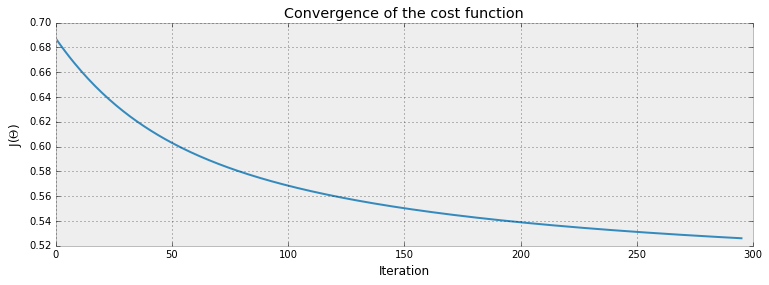

In [8]:
learning_rate = 0.1
maxepochs = 10000
convergence_thres = 0.0001

def learn(X, y, theta, learning_rate, maxepochs, convergence_thres):
    """
    Convenience function:
        learn a two layer Neural Networks
    """
    costs = []
    cost = singlecost(X, y, theta)
    costprev = cost + convergence_thres + 0.01
    counter = 0
    
    #loop through until convergence
    for counter in np.arange(maxepochs):
        grads = np.zeros(theta.shape)
        for j, obs in enumerate(X):
            h = sigmoid_activation(obs, theta)
            delta = (y[j] - h) * h * (1 - h) * obs
            grads += delta[:, np.newaxis] / X.shape[0]
            
        #update parameters
        theta += grads * learning_rate
        counter += 1
        costprev = cost
        cost = singlecost(X, y, theta)
        costs.append(cost)
        if np.abs(costprev - cost) < convergence_thres:
            break
        
    figsize(12.5, 4)
    plt.plot(costs)
    plt.title("Convergence of the cost function")
    plt.ylabel("J($\Theta$)")
    plt.xlabel("Iteration")
    plt.legend();
    return theta
    
theta = learn(X, y, theta_init, learning_rate, maxepochs, convergence_thres)

### Neural Network
Neural networks are usually built using mulitple layers of neurons. Adding more layers into the network allows you to learn more complex functions. Here's a picture representing a 3 layer neural network : 
<img src="http://localhost:8888/files/python_prog/ML/img/iris3.png", width = 300/>
We have a 3 layer neural network with four input variables $x_1$, $x_2$, $x_3$, and $x_4$ and a bias unit. Each variable and bias unit is then sent to four hidden units, $a_1^2$,$a_2^2$,$a_3^2$, and $a_4^2$. <br>The hidden units have different sets of parameters $\theta$.<br>
$$ a_1^2 = g(\theta_{1,0}^{(1)} + \theta_{1,1}^{(1)}x_1 + \theta_{1,2}^{(1)}x_2 + \theta_{1,3}^{(1)}x_3 + \theta_{1,4}^{(1)}x_4 )$$<br>
$$ a_2^2 = g(\theta_{2,0}^{(1)} + \theta_{2,1}^{(1)}x_1 + \theta_{2,2}^{(1)}x_2 + \theta_{2,3}^{(1)}x_3 + \theta_{2,4}^{(1)}x_4 )$$<br>
$$ a_3^2 = g(\theta_{3,0}^{(1)} + \theta_{3,1}^{(1)}x_1 + \theta_{3,2}^{(1)}x_2 + \theta_{3,3}^{(1)}x_3 + \theta_{3,4}^{(1)}x_4 )$$<br>
$$ a_4^2 = g(\theta_{4,0}^{(1)} + \theta_{4,1}^{(1)}x_1 + \theta_{4,2}^{(1)}x_2 + \theta_{4,3}^{(1)}x_3 + \theta_{4,4}^{(1)}x_4 )$$<br>
$\theta_{i,k}^j$ represents the parameter of input unit $k$ which transform the units in layer $j$ to activation unit $a_i^{(j+1)}$

This layer is known as a hidden layer because the user does not directly interact with it by passing or retrieving data. The third and final layer is the output, or prediction, of our model. Similar to how each variable was sent to each neuron in the hidden layer, the activation units in each neuron are then sent to each neuron on the next layer. Since there is only a single layer, we can write it as:<br><br>
$$h_{\Theta}(X) = g(\theta_{1,0}^{(2)} + \theta_{1,1}^{(2)}a_1 + \theta_{1,2}^{(2)}a_2 + \theta_{1,3}^{(2)}a_3 + \theta_{1,4}^{(2)}a_4 )$$<br>
While the mathematical notation may seem confusing at first, at a high level, we are organizing multiple logistic regression models to create a more complex function.

In [9]:
def feedforward(x, theta_0, theta_1):
    """
    Convenince function:
        compute the output of a 3 layer NNets
        feedforward to the first layer
        add a colum of ones for the bias term
    """
    a1 = sigmoid_activation(x.T, theta_0).T
    a1 = np.column_stack([np.ones(a1.shape[0]), a1])
    out = sigmoid_activation(a1.T, theta_1)
    return out

theta0_init = np.random.normal(0, 0.1, size = (5, 4))
theta1_init = np.random.normal(0, 0.1, size = (5, 1))
h = feedforward(X, theta0_init, theta1_init)    

### Multiple Neural Network Cost Function
The cost function to multiple layer neural networks is identical to the cost function we used in the last screen, but $h_{\theta}(x)$
is more complicated.
$$J(\Theta) = -\frac{1}{m} \sum_{i=1}^m (y_i * log(h_{\theta}(x_i)) + (1 - y_i) * log(1 - h_{\theta}(x_i)) $$

In [10]:
def multiplecost(X, y, theta0, theta1):
    """
    Convenience function:
        
    """
    h = feedforward(X, theta0, theta1)
    cost = -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))
    return cost

c = multiplecost(X, y, theta0_init, theta1_init)

### Backpropagation
Now that we have mulitple layers of parameters to learn, we must implement a method called $backpropagation$. We've already implemented forward propagation by feeding the data through each layer and returning an output. Backpropagation focuses on updating parameters starting at the last layer and circling back through each layer, updating accordingly.
As there are multiple layers we are forced to compute : $$ \frac{\partial}{\partial \Theta_{i,j}^{(l)}}J(\Theta)$$
where $l$ is the layer. For a three layer network, use the following approach,
$\delta_{j}^l$ is the <i>error</i> for unit $j$ in layer $l$.<br>
$$\delta^3 = h_{\Theta}(X) - y$$<br>
$$\delta^2 = (\Theta^{(2)})^T \delta^3 .* g'(z^{(2)})$$
<i>There is no $\delta^1$ since the first layer are the features and have no error.</i>

In [11]:
class NNet3:
    def __init__(self, learning_rate=0.5, maxepochs=1e4, convergence_thres=1e-5, hidden_layer=4):
        """
        convenience function:
            initialiaze the NNet parameters
        """
        self.learning_rate = learning_rate
        self.maxepochs = int(maxepochs)
        self.convergence_thres = 1e-5
        self.hidden_layer = int(hidden_layer)
        
    def _multiplecost(self, X, y):
        l1, l2 =  self._feedforward(X)
        inner = y * np.log(l2) + (1 - y) * np.log(1 - l2) # error
        return -np.mean(inner)
    
    def _feedforward(self, X):
        l1 = sigmoid_activation(X.T, self.theta0).T
        l1 = np.column_stack([np.ones(l1.shape[0]), l1])
        l2 = sigmoid_activation(l1.T, self.theta1)
        return l1, l2
    
    def predict(self, X):
        _, y = self._feedforward(X)
        return y
    
    def learn(self, X, y):
        nobs, ncols = X.shape
        self.theta0 = np.random.normal(0, 0.01, size = (ncols, self.hidden_layer))
        self.theta1 = np.random.normal(0, 0.01, size = (self.hidden_layer + 1, 1))
        
        self.costs = []
        cost = self._multiplecost(X, y)
        self.costs.append(cost)
        costprev = cost + self.convergence_thres + 1 # set an initial costprev to past while loop
        counter = 0 # initialize counter
        
        for counter in np.arange(self.maxepochs): # loop until convergence
            l1, l2 = self._feedforward(X) # start backpropagation, compute gradients
            
            l2_delta = (y - l2) * l2 * (1 - l2)
            l1_delta = l2_delta.T.dot(self.theta1.T) * l1 * (1 - l1)
            
            # update parameters by averaging gradients and multiplying by the learning rate
            self.theta1 += l1.T.dot(l2_delta.T) / nobs * self.learning_rate
            self.theta0 += X.T.dot(l1_delta)[:, 1:] / nobs * self.learning_rate
            
            # Store cost and chech for convergence
            counter += 1
            costprev = cost
            cost = self._multiplecost(X, y)
            self.costs.append(cost)
            if np.abs(costprev - cost) < self.convergence_thres and counter > 500:
                break

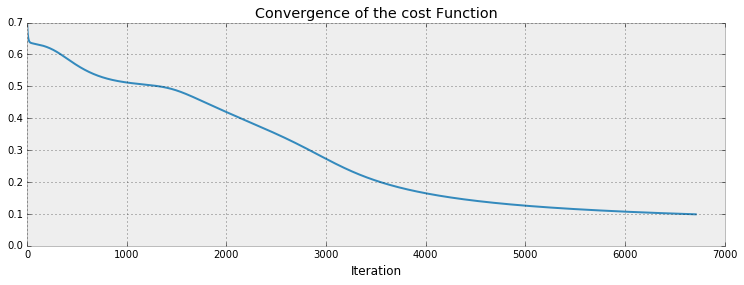

In [12]:
learning_rate = 0.5
maxepochs = 10000
convergence_thres = 0.00001
hidden_units = 4

# initialize model
model = NNet3(learning_rate=learning_rate, maxepochs=maxepochs,
             convergence_thres=convergence_thres, hidden_layer = hidden_units)

# train the model
model.learn(X, y)

# Plot costs
plt.plot(model.costs)
plt.title("Convergence of the cost Function")
plt.xlabel("J($\Theta$)")
plt.xlabel("Iteration")
plt.legend();

### Splitting data
Now that we have learned about neural networks, learned about backpropagation, and have code which will train a 3-layer neural network, we will split the data into training and test datasets and run the model

In [13]:
X_train = X[:130]
y_train = y[:130]
X_test = X[-20:]
y_test = y[-20:]

In [14]:
learning_rate = 0.5
maxepochs = 10000
convergence_thres = 0.00001
hidden_units = 4

# initialize model
model = NNet3(learning_rate=learning_rate, maxepochs=maxepochs,
             convergence_thres=convergence_thres, hidden_layer = hidden_units)

# train the model
model.learn(X_train, y_train)
probabilities = model.predict(X_test)
auc_score = roc_auc_score(y_test, probabilities[0])

In [15]:
auc_score

1.0